In [34]:
#http://solarisailab.com/archives/2387
import numpy as np  #대규모 수학 연산
import os # Operating System의 약자로서 운영체제에서 제공되는 여러 기능
import six.moves.urllib as urllib # 웹과 관련된 데이터를 쉽게 이용하게 도와주는 라이브러리
import sys #인터프리터 시스템 특화된 함수나 변수를 제공
import tarfile # tar 파일 사용
import tensorflow as tf # 텐서플로우
import zipfile # zip파일
import cv2 # open cv2 영상 이미지

#from collections import defaultdict
#from io import StringIO
from matplotlib import pyplot as plt # 시각화
from PIL import Image #이미지를 표현하는 Image 클래스


In [35]:
# 이미지를 보여주기 위한 설정
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("C:/Users/ktm\models/research") #모듈을 저장한 디렉터리 (object_detection)


In [36]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [37]:
# 물체 인식을 위해 사용할 pre-trained 모델을 다운받는다.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17' # 모델 이름
MODEL_FILE = MODEL_NAME + '.tar.gz'# 모델 확장자명
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/' # 다운받을 주소

# 학습이 완료된(Frozen) Object Detection을 위한 그래프 pb파일 경로를 지정한다.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb' # 학습완료된 모델 위치

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')  # 경로를 병합하여 새 경로 생성

#클래스의 갯수
NUM_CLASSES = 90

In [38]:
opener = urllib.request.URLopener() # url 열기
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE) # 열기
tar_file = tarfile.open(MODEL_FILE) #tar 파일 열기
for file in tar_file.getmembers(): # 아카이브 목록
  file_name = os.path.basename(file.name) # 기본이름을 반환
  if 'frozen_inference_graph.pb' in file_name: #frozen_inference_graph.pb 파일을 발견시
    tar_file.extract(file, os.getcwd()) #현제위치에 frozen_inference_graph.pb를 추출

In [39]:
detection_graph = tf.Graph() #그래프 만들기
with detection_graph.as_default(): 
  od_graph_def = tf.GraphDef() #빈 객체
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid: # PATH_TO_CKPT위치의 파일 로드
    serialized_graph = fid.read() # 읽기
    od_graph_def.ParseFromString(serialized_graph) #앞의 코드와 같이 빈 od_graph_def객체를 만든 후에, 
    #파일에서 그래프 읽어서 ParseFromString() 메서드를 이용하여 문자열을 od_graph_def 객체로 파싱

    tf.import_graph_def(od_graph_def, name='') # import

In [40]:
#라벨 맵 로드하기
lo = 'C:/Users/ktm/Anaconda3/Lib/site-packages/tensorflow/models/research/object_detection/data' # 위치
label_map = label_map_util.load_labelmap(os.path.join(lo, 'mscoco_label_map.pbtxt'))#lo 위치의 mscoco_label_map.pbtxt 파일 로드



In [41]:
# 카테고리 
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [21]:
#[utils] 폴더 내의 Wrapper 함수들을 Wrapper Module들을 통해 라벨(또는 카테고리 정보 - ID & Name)을 불러옴

In [42]:
#함수 이름 그대로 image 데이터를 numpy array 형식으로 변환하는 함수
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

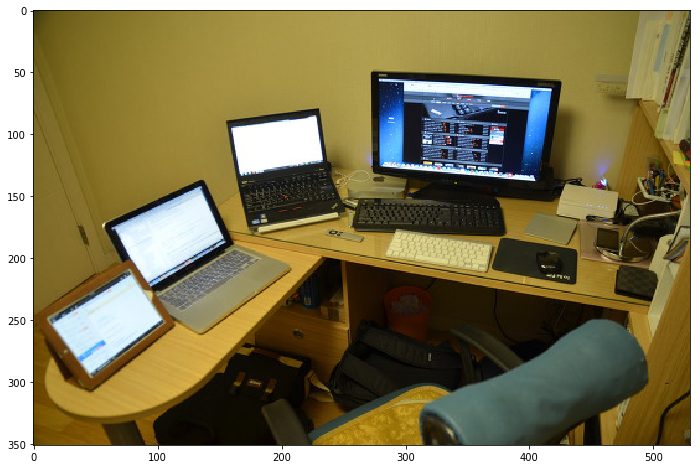

In [24]:
# 이미지 한개
IMAGE_SIZE = (12, 8)
image = Image.open('test_images/room.jpg')  
# 이미지 그리기
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)

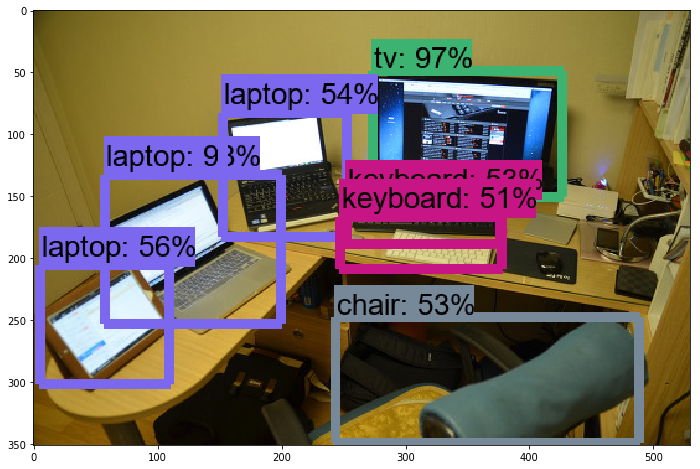

In [25]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess: # TensorFlow 세션(Session)을 수립하는데 그래프는 detection_graph를 런칭(Launching)
    # Definite input and output Tensors for detection_graph
    
    #학습 시 정의했던 이름으로 Tensor를 얻어옴
    
    
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0') 
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    
    # load_image_into_numpy_array Wrapper 모듈로부터 오픈한 이미지 데이터를 numpy array로 로딩
    image_np = load_image_into_numpy_array(image)
    
    #그래프 모델에 적합하도록 Array의 Shape을 확장
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    #이미 학습된 그래프를 통해 오브젝트를 감지 후 결과로써 
    #Bounding Box와 Bounding Box 내 오브젝트 스코어 및 클래스, 감지된 오브젝트 개수 등을 얻음
    # Actual detection.
    (boxes, scores, classes, num) = sess.run(
      [detection_boxes, detection_scores, detection_classes, num_detections],
      feed_dict={image_tensor: image_np_expanded})
   

    # visualization_utils.visualize_boxes_and_labels_on_image_array Wrapper Module을 이용하여 현재의 이미지 상에 시각화
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.squeeze(boxes),
      np.squeeze(classes).astype(np.int32),
      np.squeeze(scores),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
    
    
    
    #창을 띄워 이들을 보여줌
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

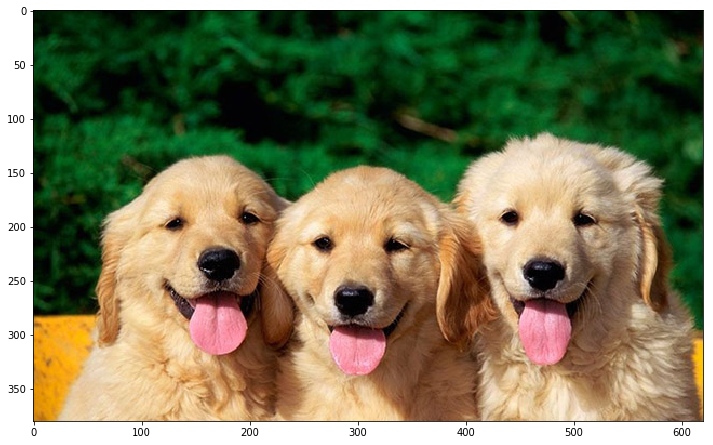

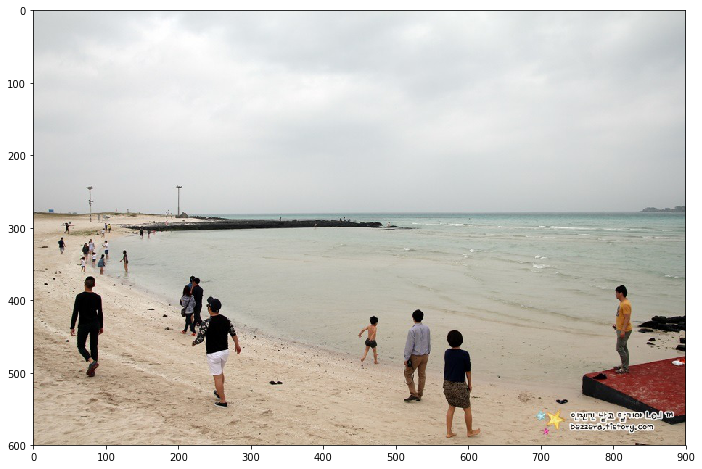

In [27]:
# 이미지 여러개.
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images' # 폴더
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ] # 파일명

# inch로 표현한 출력 이미지의 크기
IMAGE_SIZE = (12, 8)

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)    
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image)

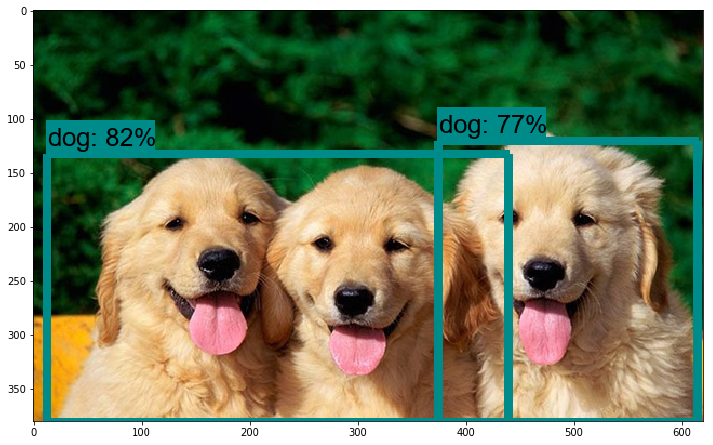

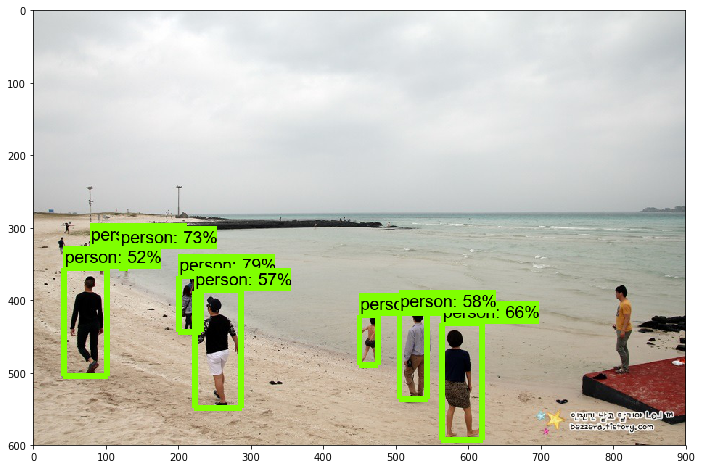

In [28]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [44]:
cap = cv2.VideoCapture('t1.mp4')

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('output.mp4', fourcc, 25.0, (640,480))

while (cap.isOpend()):
    ret, image = cap.read()

    if ret:

        

        image_np_expanded = np.expand_dims(image, axis=0)
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
   
        scores = detection_graph.get_tensor_by_name('detection_scores:0')
        classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
                
                # Actual detection.
        (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
                
                # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
                image,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)
        out.write(image)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

AttributeError: 'cv2.VideoCapture' object has no attribute 'isOpend'